# How Predictable are Humans ? (ADAes Team) 

Wikispeedia is a game based on Wikipedia, where players are given a start and end article and they must reach their goal in the fastest time possible only by using Wikipedia hyperlinks.

This study aims at analysing players strategies in order to leverage out insightful conclusions about their navigational behaviour.

Table of content :  
1. [Can this behaviour be generalised](#1.-Can-this-behaviour-be-generalised-?) 
2. [What is the semantic meaning of these paths](#2.-What-is-the-semantic-meaning-of-these-paths-?)
3. [Is this strategy optimal?](#3.-Is-this-strategy-optimal-?)

# Importing Data and Libraries

In [42]:
# Import packages 
import pandas as pd
import networkx as nx
from helpers import *
import pickle
import os
from functools import reduce
import json
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import umap.umap_ as umap
import matplotlib.pyplot as plt
#import hdbscan
#from bertopic import BERTopic
from numpy import array, average
import math
from matplotlib.pyplot import figure
from ast import literal_eval
from scipy import stats
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import interpolate
import plotly.express as px


In [2]:
# Import data 

#Import DataFrames generated in Data_Engineering.ipynb
df_nodes_topics = pd.read_pickle('data/df_nodes_topics.pkl')
df_nodes = pd.read_pickle('data/df_nodes.pkl')
df_topics_general = pd.read_pickle('data/df_topics_general.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics_df.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics.pkl')
df_paths_finished = pd.read_pickle('data/df_paths_finished.pkl')
df_paths_unfinished = pd.read_pickle('data/df_paths_unfinished.pkl')

# Import NetworkX Graphs generated in Data_Engineering.ipynb
G_topics = nx.read_gpickle('data/G_topics.gpickle')
G_general_topics = nx.read_gpickle('data/G_general_topics.gpickle')
G_articles = nx.read_gpickle('data/G_articles.gpickle')

df_embeddings = pd.read_pickle('data/embeddings.pickle')

# Import useful dicts generated in Data_Engineering.ipynb
with open('data/closeness_dict.pkl','rb') as f:
    closeness_dict = pickle.load(f)
with open('data/closeness_topics_dict.pkl','rb') as f:
    closeness_topics_dict = pickle.load(f)  
with open('data/pagerank_topics_dict.pkl','rb') as f:
    pagerank_topics_dict = pickle.load(f)  

with open('data/pagerank_dict.pkl','rb') as f:
    pagerank_dict = pickle.load(f)  
    
with open('data/betweenness_dict.pkl','rb') as f:
    betweenness_dict = pickle.load(f)
with open('data/betweenness_topics_dict.pkl','rb') as f:
    betweenness_topics_dict = pickle.load(f)    

In [3]:
# We define the constatns for the analysis
OUT_DEGREE = 'out_degree'
CLOSENESS = 'closeness'
PAGERANK = 'pagerank'
BETWEENNESS = 'betweenness'
SEMANTIC = 'sematic similarity'
CENTRALITY_MEASURES = [OUT_DEGREE, CLOSENESS, PAGERANK, BETWEENNESS]

AVERAGE_PATH_LENGTH = round(df_paths_finished['path_length'].mean())
K = 10

In [4]:
# We define the data schema for the analysis
class DataSchema :
    """This class defines the data schema for the analysis
    """

    START = 'start'
    TARGET = 'target'
    PATH = 'path'
    VISITS = 'visits'
    DURATION = 'durationInSec'
    PATH_LENGTH = 'path_length'
    TIME_PER_ARTICLE = 'time_per_article'
    TYPE = 'type'



# 1. Can this behaviour be generalised ?

## 1.1 Are the most central nodes the most visited ones ? 

### 1.1.1 What are the most central nodes ?

In [5]:
# We rank the nodes according to diffenrent centrality measures and store the results in a DataFrame
df_order_per_metric = pd.DataFrame(columns=CENTRALITY_MEASURES, index=['Rank {}'.format(i+1) for i in range(df_nodes.shape[0])])
for measure in CENTRALITY_MEASURES:
    df_order_per_metric[measure] = df_nodes.sort_values(by=measure, ascending=False).reset_index()['name'].tolist()
df_order_per_metric.columns = pd.MultiIndex.from_product([['Centrality Measures'], df_order_per_metric.columns])

In [6]:
# We print the most central nodes according to the different centrality measures
print('The most central nodes according to the different centrality measures are:')
df_ranked_metrics = df_order_per_metric
df_ranked_metrics.to_pickle('data_viz/df_ranked_metrics.pkl')
df_ranked_metrics.head(AVERAGE_PATH_LENGTH)

The most central nodes according to the different centrality measures are:


Centrality Measures                                                  
                out_degree       closeness          pagerank     betweenness
Rank 1       United_States   United_States     United_States   United_States
Rank 2      United_Kingdom          Europe            France  United_Kingdom
Rank 3              France  United_Kingdom            Europe         England
Rank 4              Europe          France    United_Kingdom          Europe
Rank 5             England         Germany  English_language          Africa
Rank 6        World_War_II    World_War_II           Germany         Germany

### 1.1.2 What are the most visited nodes ? 

In [7]:
# We sort and display the most visited nodes 
print('The most visited nodes are :')
display(df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)[[DataSchema.VISITS]].head(AVERAGE_PATH_LENGTH))

The most visited nodes are :


,visits
name,
United_States,11991.0
Europe,5397.0
United_Kingdom,5021.0
England,4255.0
Earth,4095.0
Africa,3446.0


### 1.1.3 Are the most central nodes the most visited ones ?

In [8]:
# We add columns for the rank of each article in each centrality measure
for measure in CENTRALITY_MEASURES: 
    df_nodes[measure+'_rank'] = df_nodes[measure].rank(ascending=False)

# We add a column for the rank of each article in terms of visits
df_nodes[DataSchema.VISITS+'_rank'] = df_nodes[DataSchema.VISITS].rank(ascending=False)

In [9]:
# We sort and display the articles and their rank in each centrality measure
df_nodes = df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)
df_nodes[[DataSchema.VISITS+'_rank', 'out_degree_rank', 'closeness_rank', 'betweenness_rank', 'pagerank_rank']].head(AVERAGE_PATH_LENGTH)

,visits_rank,out_degree_rank,closeness_rank,betweenness_rank,pagerank_rank
name,,,,,
United_States,1.0,1.0,1.0,1.0,1.0
Europe,2.0,4.0,2.0,4.0,3.0
United_Kingdom,3.0,2.0,3.0,2.0,4.0
England,4.0,5.5,10.0,3.0,8.0
Earth,5.0,49.0,56.0,11.0,35.0
Africa,6.0,20.0,23.0,5.0,20.0


In [10]:
# compute correlation between visits rank and other ranks 
correlations = []

In [11]:
# We choose the Wasserstein distance to measure how close are the ranks of the centrality measures and the visits
dist = [wasserstein_distance(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank']) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The waterstein distance between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))


The waterstein distance between the visits and out_degree is 17.266072980017373
The waterstein distance between the visits and closeness is 19.434622067767144
The waterstein distance between the visits and pagerank is 19.822328410078182
The waterstein distance between the visits and betweenness is 45.19113814074715


In [12]:
# We choose mean squared error to measure how close are the ranks of the centrality measures and the visits
dist = [mean_squared_error(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank'], squared=False) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The mean squared error between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))

The mean squared error between the visits and out_degree is 748.9033172906907
The mean squared error between the visits and closeness is 766.9629173810858
The mean squared error between the visits and pagerank is 858.9102120648158
The mean squared error between the visits and betweenness is 888.6690326234368


In [13]:
# We choose mean absolute error to measure how close are the ranks of the centrality measures and the visits
dist = [mean_absolute_error(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank']) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The mean absolute error between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))

The mean absolute error between the visits and out_degree is 550.1859252823632
The mean absolute error between the visits and closeness is 563.7208948740226
The mean absolute error between the visits and pagerank is 620.3998696785404
The mean absolute error between the visits and betweenness is 649.8464378801043


As we can see, the most visited nodes also perfom strongly on centrality measures. This confirms our intuition about players' strategy and the fact that they have a tendency to visit more central nodes.

Moreover, we try different metrics to measure which centrality measure best reflects the visits of the players. We observe that all the metrics yield the same answer and we can safely conclude that the out-degree best represents the behavior of the players. 

## 1.2 What is the evolution of the centrality of the nodes visited in the players' path ?

In [14]:
# We define a function to get the k most played games 
def get_top_k_games(df_paths_finished, k):
    df_top_k = (
        df_paths_finished[[DataSchema.START, DataSchema.TARGET, DataSchema.PATH]]
        .groupby([DataSchema.START, DataSchema.TARGET])
        .count()
        .sort_values(by=DataSchema.PATH, axis=0, ascending=False)[:k]
    )
    top_k_games = df_top_k.index
    return top_k_games

In [15]:
# We define a function to find how many different players have played certain games 
def get_number_players(df_paths_finished, top_k_games):
    top_start = [i[0] for i in top_k_games]
    top_target = [i[1] for i in top_k_games]
    top_paths = list(zip(top_start, top_target))

    df_pruned = df_paths_finished.merge(
        pd.DataFrame(top_paths, columns=[DataSchema.START, DataSchema.TARGET]),
        how="inner",
        on=[DataSchema.START, DataSchema.TARGET],
    )
    return df_pruned.hashedIpAddress.nunique()

In [16]:
# We define a function to plot the  average evolution of a centrality measure for the top k paths
def plot_average_evolution(
    df_paths_finished, k, measure, df_nodes=None, df_embeddings=None
):
    top_k_games = get_top_k_games(df_paths_finished, k)
    num_rows = math.floor(math.sqrt(K))
    num_cols = k // num_rows
    num_cols = num_cols if K % num_rows == 0 else num_cols + 1
    figure, axis = plt.subplots(num_rows, num_cols)

    for i, game in enumerate(top_k_games):
        path_measure = []

        df_games = df_paths_finished[
            [DataSchema.START, DataSchema.TARGET, DataSchema.PATH]
        ]
        mask = (df_games[DataSchema.START] == game[0]) & (
            df_games[DataSchema.TARGET] == game[1]
        )
        df_games = df_games[mask]
        num_games = df_games.shape[0]

        if measure in CENTRALITY_MEASURES:
            path_measure = list(
                df_games[DataSchema.PATH].apply(
                    lambda l: [df_nodes.loc[elem][measure] for elem in l]
                )
            )
        else:
            paths = df_games[DataSchema.PATH].values
            for path in paths:
                list_of_articles = path[:-1]
                target_article = path[-1]
                path_measure.append(
                    compute_cosine_similarity(
                        df_embeddings, list_of_articles, target_article
                    )
                )

        xs, ys, l, u = get_value_evolution(path_measure)
        ax = axis[i % num_rows, i // num_rows]
        ax.plot(xs, ys)
        ax.fill_between(xs, l, u, alpha=0.2)
        ax.set_title(
            "{} to {} (Averaged {} games)".format(game[0], game[1], num_games),
            fontsize=12,
        )

    figure.suptitle(
        "Average evolution of {} centrality for the top {} paths".format(measure, k),
        fontsize=20,
    )
    figure.set_size_inches(18.5, 10.5)
    figure.tight_layout()


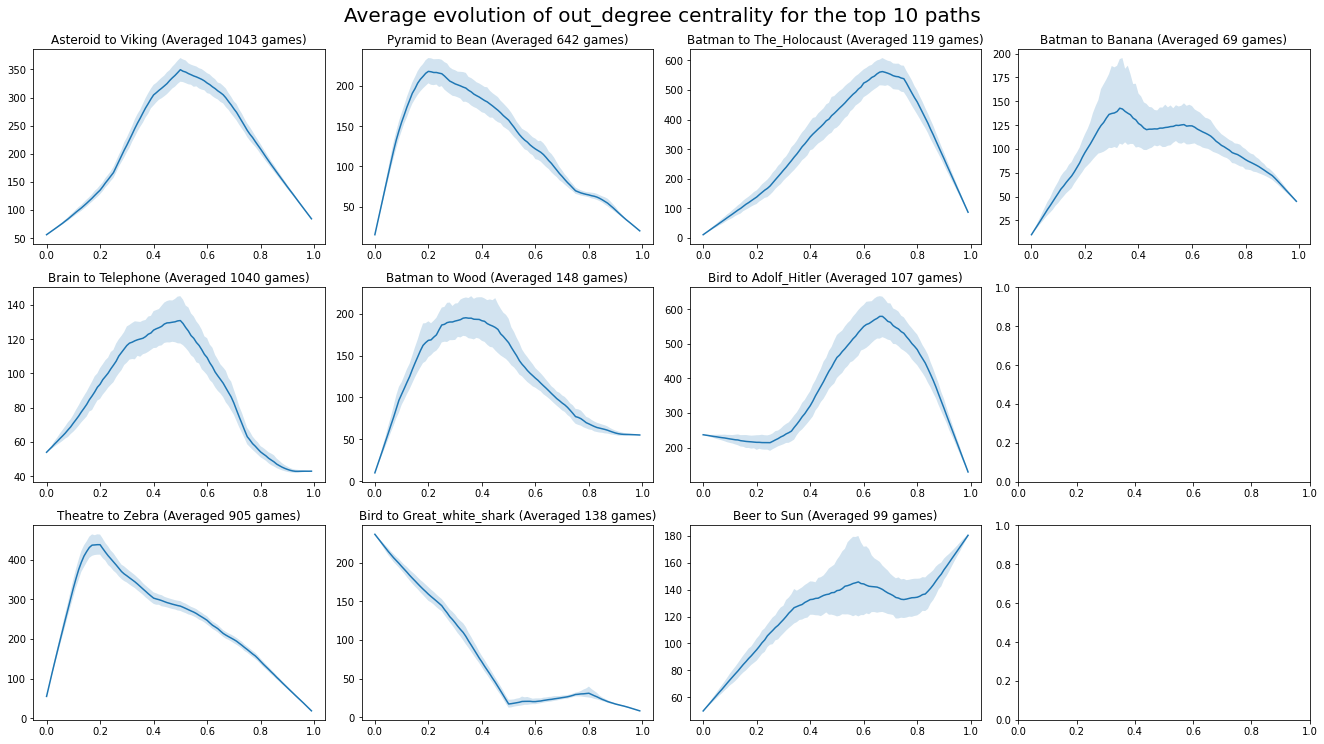

In [17]:
plot_average_evolution(df_paths_finished, K, OUT_DEGREE,df_nodes=df_nodes)

In [18]:
# We emphasize statistical significance based on how many players are involved in this study 
print('The number of unique players to have participated in this study is :', get_number_players(df_paths_finished, get_top_k_games(df_paths_finished, 10)))

The number of unique players to have participated in this study is : 2693


This study realised above further confirms our intution about players' strategy. We can clearly observe the evolution of the centrality measure along the path, and we see that players first move towards central nodes before focusing back on the target. 

This conclusion draws it's statistical significance from the confidence intervals of the curves as each curve was obtained by averaging many paths played. Moreover, 2693 players were involved in this study. 
Both those arguments make a solid statement that this behaviour is generalisable as we observe a great number of players converging towards the same strategy.

## 1.3 What is the evolution of the centrality of the nodes visited in the shortest path ? 

In [19]:
# Function that yields shortest path from start to end 
def get_shortest_path(G,start,end):
    return nx.shortest_path(G,start,end)

In [20]:
# Function that plots the centrality measure of the shortest path from start to end
def plot_centrality_shortest_path(df_paths_finished, G_articles, measure, k=K):
    top_k_games = get_top_k_games(df_paths_finished, k)
    shortest_paths = [get_shortest_path(G_articles,game[0],game[1]) for game in top_k_games]
    path_measure = [[df_nodes.loc[elem][measure] for elem in path] for path in shortest_paths]
        
    num_rows = math.floor(math.sqrt(k))
    num_cols = k // num_rows 
    num_cols = num_cols if k%num_rows==0 else num_cols + 1
    figure, axis = plt.subplots(num_rows, num_cols)

    for i in range(k):
        ax = axis[i % num_rows, i // num_rows]
        ax.plot(path_measure[i])
        ax.set_title("{} to {}".format(top_k_games[i][0], top_k_games[i][1]), fontsize=15)
        
    figure.suptitle(
        "{} Evolution of Shortest Path".format(measure),
        fontsize=20,
    )
    figure.set_size_inches(18.5, 10.5)
    figure.tight_layout()

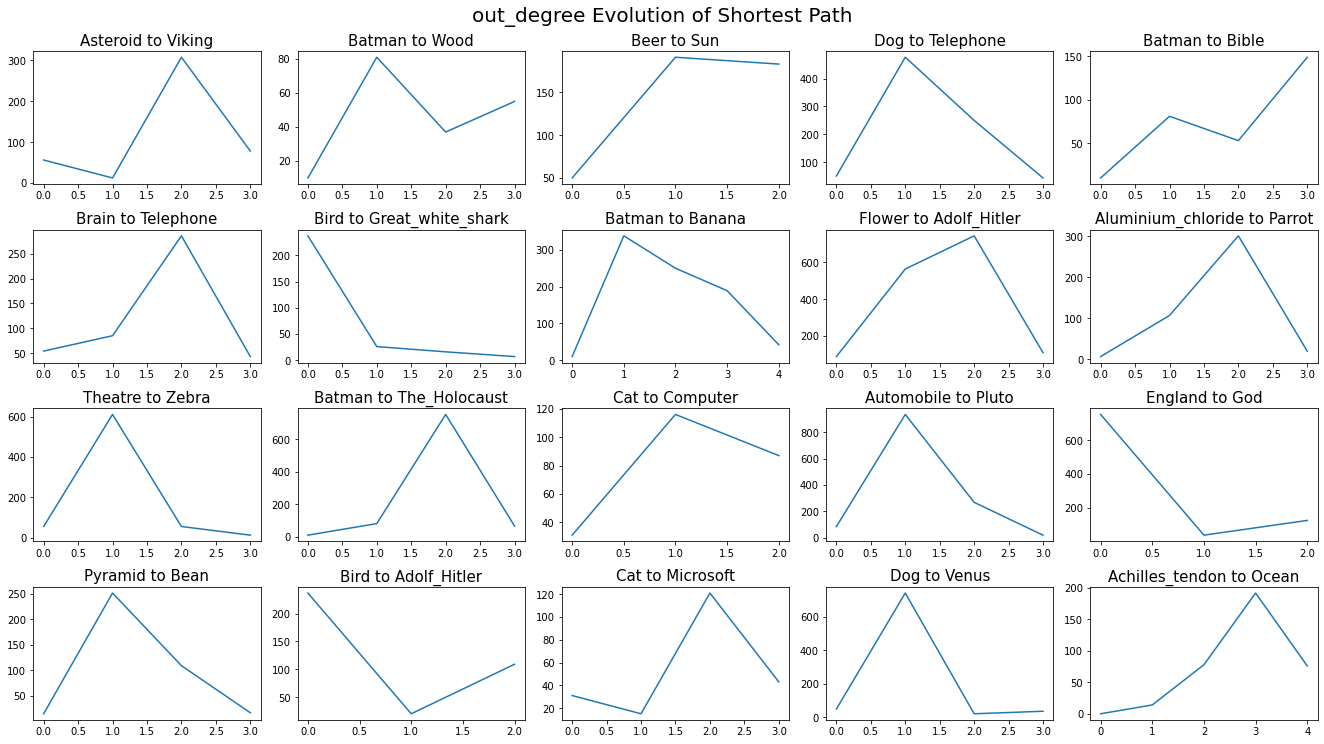

In [21]:
plot_centrality_shortest_path(df_paths_finished, G_articles, OUT_DEGREE, 20)

We observe that the evolution of the centrality of the nodes visited along the shortest path follow a similar behavior to the players. This can be explained by properties of real world networks. Degree distribution tends to be skewed, and some nodes effectively act as hubs and allow for very short paths to be found. Moreover, in such networks, short paths are easily discoverable via greedy decentralized routing. In light of that, we conclude that shortest paths follow this centrality evolution as shortest paths tend to go through hubs. And players also follow a similar strategy by greed, although they do not always find the **shortest** path.

# 2. What is the semantic meaning of these paths ?

## 2.1 Is the player getting semantically closer to the goal ?

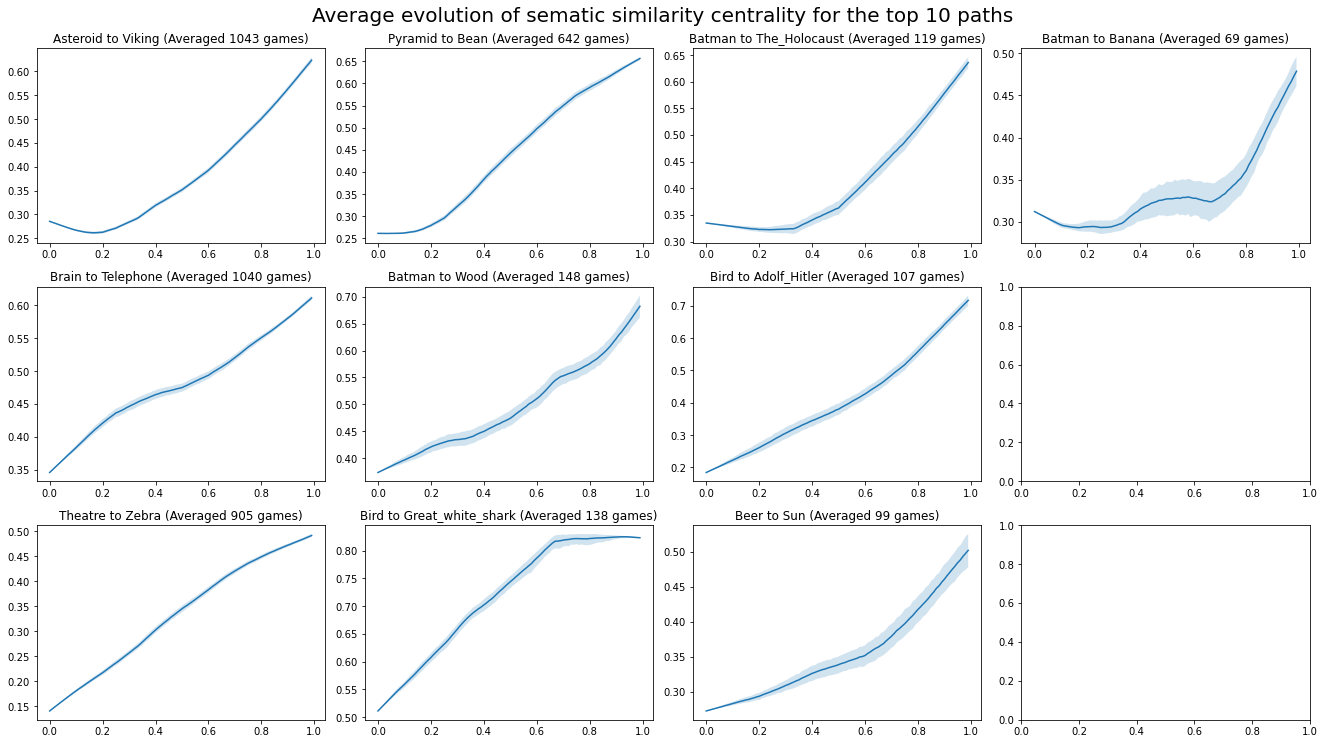

In [22]:
# Plot the evolution of the semantic closeness from each hop to the target page as we progress through the path
plot_average_evolution(df_paths_finished, K, SEMANTIC ,df_embeddings=df_embeddings)

From the above plots, we see that players reason logically about their choices. There is a clear notion of semantic in the decisions of the players as the semantic similarity increases along the path. This unveils the full strategy of the players' as not only do they tend to go through central nodes, but they also factor in semantic closeness to the target when making their choice.

## 2.2 Does shortest path reflect semantic closeness/similarity ?

In [23]:
# Compute similarities from each node to the target node for the shortest path of the top K most played games
def get_sim_shortest_path(k,G_articles,df_paths_finished,df_embeddings):
    top_k_games = get_top_k_games(df_paths_finished, k)
    top_k_games_paths = []
    similarities = []
    for pair in set(top_k_games):
        top_k_games_paths.append(get_shortest_path(G_articles,pair[0],pair[1]))

    for i in range(k):
        list_of_articles = top_k_games_paths[i][:-1]
        target_article = top_k_games_paths[i][-1]
        similarities.append(compute_cosine_similarity(df_embeddings,list_of_articles, target_article))

    return (top_k_games,similarities)

In [24]:
# Plot the semantic evolution of the shortest path of the top K most played games
def plot_semantic_shortest_path(G_articles, df_paths_finished, df_embeddings, k):
    (top_k_games,similarities) = get_sim_shortest_path(k,G_articles,df_paths_finished,df_embeddings)
    
    num_rows = math.floor(math.sqrt(k))
    num_cols = k // num_rows 
    num_cols = num_cols if K%num_rows==0 else num_cols + 1
    figure, axis = plt.subplots(num_rows, num_cols)

    for i in range(k):
        ax = axis[i % num_rows, i // num_rows]
        ax.plot(similarities[i])        
        ax.set_title("{} to {}".format(top_k_games[i][0], top_k_games[i][1]), fontsize=15)
        
    figure.suptitle(
        "Semantic Evolution over Shortest Path".format(len(similarities)),
        fontsize=20,
    )
    figure.set_size_inches(18.5, 10.5)
    figure.tight_layout()

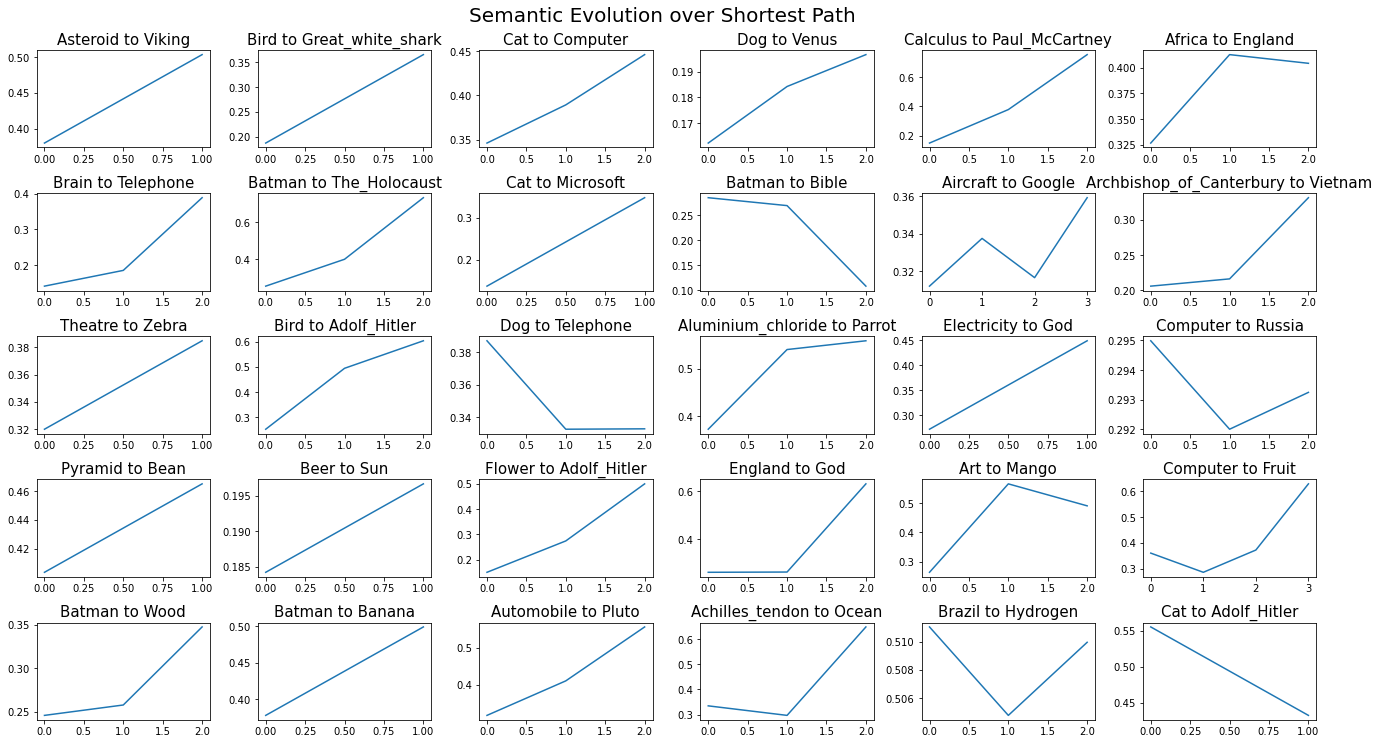

In [25]:
plot_semantic_shortest_path(G_articles, df_paths_finished, df_embeddings, 30)

From the above plots, we discover a major difference that keeps the players from reaching the shortest paths. Indeed, shortest paths do not seem to follow semantic distance in the path, which is counter intuitive for human players but allows algorithms with a global view of the network to find the optimal routing. 

### Now that we have unveiled deeper insights about players' behavior and what keeps them from reaching optimility in the Wikispeedia game, we decide to investigate further improvements that can help players get closer to the shortest path.

# 3. Is this strategy optimal ? 

## 3.1 Is this strategy the one that yields the most winner paths ? 

In [26]:
df_unfinished_played = df_paths_unfinished[df_paths_unfinished['path'].apply(lambda x : len(x)>1)]

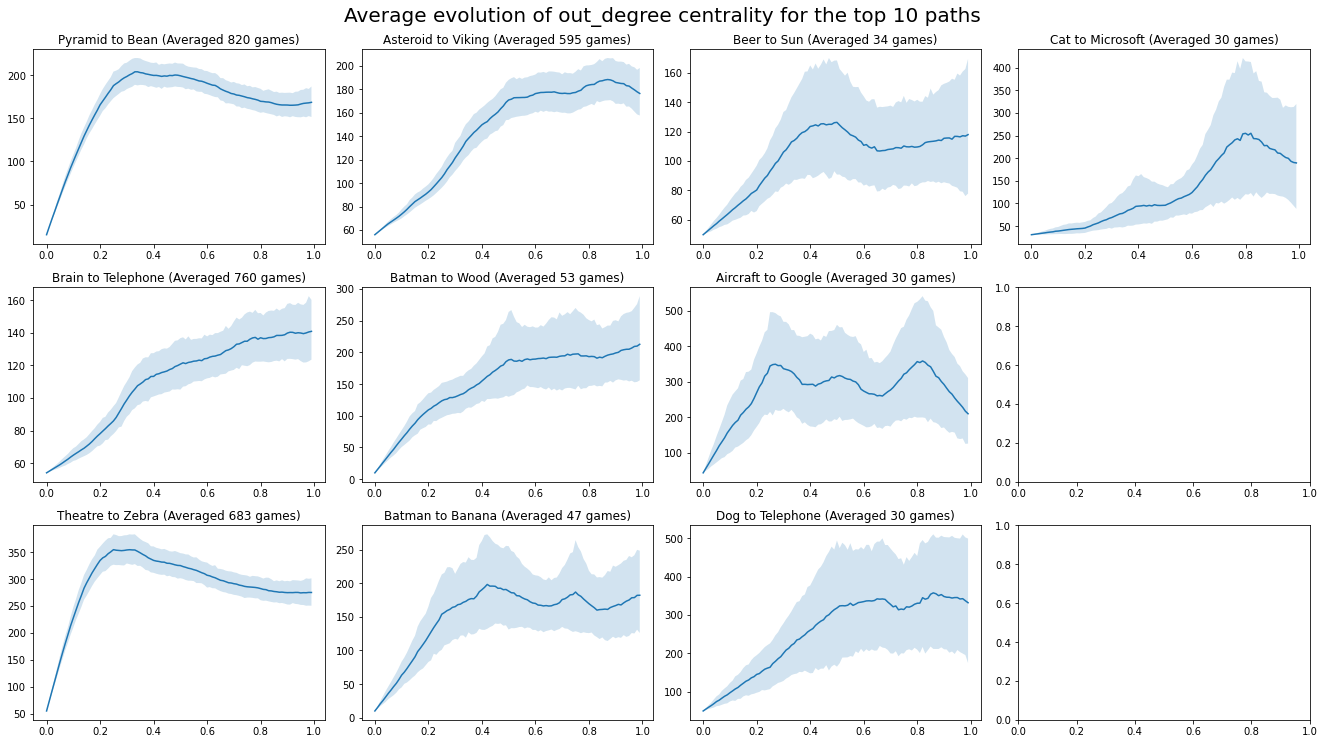

In [27]:
plot_average_evolution(df_unfinished_played, K, OUT_DEGREE, df_nodes=df_nodes)

### Exploration

### Hypothesis testing

In [28]:
# remove rows where type = timeout
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished[DataSchema.TYPE] != 'timeout']

In [29]:
avg_finished = df_paths_finished[DataSchema.TIME_PER_ARTICLE].mean()
avg_unfinished = df_paths_unfinished[DataSchema.TIME_PER_ARTICLE].mean()
print(avg_finished, avg_unfinished)

24.88579894047828 45.97494932802411


In [30]:
stat, p_value = stats.ttest_ind(df_paths_finished[DataSchema.TIME_PER_ARTICLE], df_paths_unfinished[DataSchema.TIME_PER_ARTICLE], alternative='less', equal_var=False)
print(stat, p_value)

-33.43095564476067 6.029568582117581e-239


In [31]:
# Function that tests the hypothesis that the time_per_article is lower in finished games than in unfinished games (using Bejamini-Hochberg correction)
def get_k_BH_test(df_paths_finished, df_paths_unfinished, k, alpha=0.05):
    topk = get_top_k_games(df_paths_finished, k)
    summary = {}

    for start, target in topk:
        fin = df_paths_finished[(df_paths_finished[DataSchema.START] == start) & (df_paths_finished[DataSchema.TARGET] == target)][DataSchema.TIME_PER_ARTICLE]
        unfin = df_paths_unfinished[(df_paths_unfinished[DataSchema.START] == start) & (df_paths_unfinished[DataSchema.TARGET] == target)][DataSchema.TIME_PER_ARTICLE]
        _, p_value = stats.ttest_ind(fin, unfin, alternative='less', equal_var=False)
        summary[(start, target)] = p_value

    summary = dict(sorted(summary.items(), key=lambda item: item[1]))

    for count, (key, value) in enumerate(summary.items()):
        thresh = ((count + 1) * alpha) / k
        summary[key] = (value, value < thresh)

    for key, value in summary.items():
        print('{} to {} : p_value = {:.3f}, reject_null = {}'.format(key[0], key[1], value[0], value[1]))

In [32]:
get_k_BH_test(df_paths_finished, df_paths_unfinished, K)

Brain to Telephone : p_value = 0.000, reject_null = True
Pyramid to Bean : p_value = 0.000, reject_null = True
Asteroid to Viking : p_value = 0.000, reject_null = True
Batman to Wood : p_value = 0.000, reject_null = True
Beer to Sun : p_value = 0.005, reject_null = True
Bird to Adolf_Hitler : p_value = 0.007, reject_null = True
Batman to Banana : p_value = 0.016, reject_null = True
Batman to The_Holocaust : p_value = 0.027, reject_null = True
Theatre to Zebra : p_value = 0.028, reject_null = True
Bird to Great_white_shark : p_value = 0.061, reject_null = False


All the hypothesis testing point towards the fact that winners spend less time per article than loosers. This yields insights about their decision making. If you spend less time per article, you have less time to focus on semantics and choose the "perfect" next node. If you oblige yourself to go fast, than it is the best way for you to make choices that are not semantically perfect. In that sense, you get closer to the behaviour of the shortest path.

### Filter shortest paths with strictly increasing semantic 

In [33]:
paths = []
for path in nx.all_shortest_paths(G_articles, 'Asteroid', 'Viking'):
    paths.append(path)
    print(path)

['Asteroid', '1_Ceres', 'Paris', 'Viking']
['Asteroid', 'Carl_Friedrich_Gauss', 'Denmark', 'Viking']
['Asteroid', 'Comet', 'Denmark', 'Viking']
['Asteroid', 'Comet', 'English_language', 'Viking']
['Asteroid', 'Moon', 'English_language', 'Viking']
['Asteroid', 'Dinosaur', 'London', 'Viking']
['Asteroid', 'Earth', 'Atlantic_Ocean', 'Viking']
['Asteroid', 'Earth', 'Canada', 'Viking']
['Asteroid', 'Moon', 'Canada', 'Viking']
['Asteroid', 'Earth', 'Middle_Ages', 'Viking']
['Asteroid', 'Moon', 'Middle_Ages', 'Viking']
['Asteroid', 'Earth', 'Weather', 'Viking']
['Asteroid', 'Moon', 'Ireland', 'Viking']
['Asteroid', 'Telescope', 'Ireland', 'Viking']
['Asteroid', 'Telescope', 'Spain', 'Viking']


In [34]:
def check_condition(arr, threshold=0.05):
    assert len(arr) > 1
    return all(arr[i] >= arr[i-1] or arr[i-1] - arr[i] <= threshold for i in range(1, len(arr)))

In [35]:
for path in paths: 
    sim = compute_cosine_similarity(df_embeddings, path[:-1], path[-1])
    sim = [item for sublist in sim for item in sublist]
    print(path, check_condition(sim))

['Asteroid', '1_Ceres', 'Paris', 'Viking'] False
['Asteroid', 'Carl_Friedrich_Gauss', 'Denmark', 'Viking'] True
['Asteroid', 'Comet', 'Denmark', 'Viking'] True
['Asteroid', 'Comet', 'English_language', 'Viking'] True
['Asteroid', 'Moon', 'English_language', 'Viking'] True
['Asteroid', 'Dinosaur', 'London', 'Viking'] False
['Asteroid', 'Earth', 'Atlantic_Ocean', 'Viking'] False
['Asteroid', 'Earth', 'Canada', 'Viking'] False
['Asteroid', 'Moon', 'Canada', 'Viking'] True
['Asteroid', 'Earth', 'Middle_Ages', 'Viking'] False
['Asteroid', 'Moon', 'Middle_Ages', 'Viking'] True
['Asteroid', 'Earth', 'Weather', 'Viking'] False
['Asteroid', 'Moon', 'Ireland', 'Viking'] True
['Asteroid', 'Telescope', 'Ireland', 'Viking'] True
['Asteroid', 'Telescope', 'Spain', 'Viking'] True


In [36]:
# Is this strategy the one that yields the most winner paths?

In [37]:
# Here compute same procedure to loosing games 

In [38]:
# Plot evolution of centrality on shortest path 

In [39]:
# Compute overall success rate of the strategy

# This function filters out functions
def get_path_strategy(startegy, list_all_paths):
    pass

# In this case, we intend on feeding the function with already filtered paths that follow the strategy of interest
def success_rate(list_winner_paths, list_looser_paths):
    pass

In [40]:
# Wrap up and draw final conclusions about predictability of human behaviour

In [44]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [57]:
def get_values(df_paths_finished, k, measure, df_nodes=None, df_embeddings=None):
    top_k_games = get_top_k_games(df_paths_finished, k)
    mapping = {}
    for i, game in enumerate(top_k_games):
        path_measure = []

        df_games = df_paths_finished[
            [DataSchema.START, DataSchema.TARGET, DataSchema.PATH]
        ]
        mask = (df_games[DataSchema.START] == game[0]) & (
            df_games[DataSchema.TARGET] == game[1]
        )
        df_games = df_games[mask]
        num_games = df_games.shape[0]

        if measure in CENTRALITY_MEASURES:
            path_measure = list(
                df_games[DataSchema.PATH].apply(
                    lambda l: [df_nodes.loc[elem][measure] for elem in l]
                )
            )
        else:
            paths = df_games[DataSchema.PATH].values
            for path in paths:
                list_of_articles = path[:-1]
                target_article = path[-1]
                path_measure.append(
                    compute_cosine_similarity(
                        df_embeddings, list_of_articles, target_article
                    )
                )

        xs, ys, l, u = get_value_evolution(path_measure)
        mapping[game] = (xs, ys, l, u, num_games)
    
    return mapping

In [59]:
vals = get_values(df_paths_finished, K, OUT_DEGREE, df_nodes=df_nodes)
vals[('Asteroid', 'Viking')]

([0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.06,
  0.07,
  0.08,
  0.09,
  0.1,
  0.11,
  0.12,
  0.13,
  0.14,
  0.15,
  0.16,
  0.17,
  0.18,
  0.19,
  0.2,
  0.21,
  0.22,
  0.23,
  0.24,
  0.25,
  0.26,
  0.27,
  0.28,
  0.29,
  0.3,
  0.31,
  0.32,
  0.33,
  0.34,
  0.35,
  0.36,
  0.37,
  0.38,
  0.39,
  0.4,
  0.41,
  0.42,
  0.43,
  0.44,
  0.45,
  0.46,
  0.47,
  0.48,
  0.49,
  0.5,
  0.51,
  0.52,
  0.53,
  0.54,
  0.55,
  0.56,
  0.57,
  0.58,
  0.59,
  0.6,
  0.61,
  0.62,
  0.63,
  0.64,
  0.65,
  0.66,
  0.67,
  0.68,
  0.69,
  0.7,
  0.71,
  0.72,
  0.73,
  0.74,
  0.75,
  0.76,
  0.77,
  0.78,
  0.79,
  0.8,
  0.81,
  0.82,
  0.83,
  0.84,
  0.85,
  0.86,
  0.87,
  0.88,
  0.89,
  0.9,
  0.91,
  0.92,
  0.93,
  0.94,
  0.95,
  0.96,
  0.97,
  0.98,
  0.99],
 [56.0,
  59.40346018216682,
  62.802438370086286,
  66.18113583892618,
  69.57411340364334,
  73.0085337008629,
  76.43542548418024,
  80.18327402684564,
  83.98797952061362,
  87.95285341323105,
  91.8249814

In [75]:
def plot_ply(values):
    num_rows = math.floor(math.sqrt(len(values)))
    num_cols = len(values) // num_rows
    num_cols = num_cols if K % num_rows == 0 else num_cols + 1

    fig = make_subplots(
        rows=num_rows,
        cols=num_cols,
        subplot_titles=["{} to {} (Averaged {} games)".format(key[0], key[1], value[4]) for key, value in values.items()]
    )

    for i, (key, value) in enumerate(values.items()):
        row = i // num_cols + 1
        col = i % num_cols + 1
        fig.add_trace(
            go.Scatter(
                x=value[0], 
                y=value[1], 
                mode='lines',
                showlegend=False
            ),
            row=row,
            col=col
        )
        fig.add_trace(
            go.Scatter(
                x=value[0], 
                y=value[2], 
                mode='none', 
                fill='tonexty',
                showlegend=False
            ),
            row=row,
            col=col
        )
        fig.add_trace(
            go.Scatter(
                x=value[0], 
                y=value[3], 
                mode='none', 
                fill='tonexty',
                showlegend=False
            ),
            row=row,
            col=col
        )

    fig.update_layout(height=900, width=1100, title_text="Evolution of centrality measures on shortest path")
    fig.show()

In [76]:
plot_ply(vals)

In [55]:
# We define a function to plot the  average evolution of a centrality measure for the top k paths
def test(
    df_paths_finished, k, measure, df_nodes=None, df_embeddings=None
):
    top_k_games = get_top_k_games(df_paths_finished, k)
    num_rows = math.floor(math.sqrt(K))
    num_cols = k // num_rows
    num_cols = num_cols if K % num_rows == 0 else num_cols + 1
    fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=["{} to {} (Averaged {} games)".format(game[0], game[1], ) for game in top_k_games])

    for i, game in enumerate(top_k_games):
        path_measure = []

        df_games = df_paths_finished[
            [DataSchema.START, DataSchema.TARGET, DataSchema.PATH]
        ]
        mask = (df_games[DataSchema.START] == game[0]) & (
            df_games[DataSchema.TARGET] == game[1]
        )
        df_games = df_games[mask]
        num_games = df_games.shape[0]

        if measure in CENTRALITY_MEASURES:
            path_measure = list(
                df_games[DataSchema.PATH].apply(
                    lambda l: [df_nodes.loc[elem][measure] for elem in l]
                )
            )
        else:
            paths = df_games[DataSchema.PATH].values
            for path in paths:
                list_of_articles = path[:-1]
                target_article = path[-1]
                path_measure.append(
                    compute_cosine_similarity(
                        df_embeddings, list_of_articles, target_article
                    )
                )

        xs, ys, l, u = get_value_evolution(path_measure)


        fig.add_trace(
            go.Scatter(x=xs, y=ys),
            row=i % num_rows + 1, col=i // num_rows + 1
        )
    fig.update_layout(height=600, width=800, title_text="Average evolution of {} centrality for the top {} paths".format(measure, k))
    fig.show()  
    


In [56]:
test(df_paths_finished, K, OUT_DEGREE, df_nodes=df_nodes)

NameError: free variable 'num_games' referenced before assignment in enclosing scope